In [1]:
import pandas as pd
import mysql.connector
import os


# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('order_items.csv', 'order_items'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password= '12345',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/DELL/Desktop/python and sql project Target'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state            

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db= mysql.connector.connect(
    host='localhost',
    user='root',
    password= '12345',
    database='ecommerce'
)
cur = db.cursor()

# List all unique cities where customers are located.


In [39]:
query= """select distinct customer_city from customers"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data, columns=["Customer City"])
df.head(10)

,Customer City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# Count the number of orders placed in 2017.


In [11]:
query= """Select count(order_id) from orders where Year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data= cur.fetchall()

"Total Orders Places in 2017 are", data[0][0]

('Total Orders Places in 2017 are', 45101)

# Find the total sales per category.


In [15]:
query= """select p.product_category As category,
Round(Sum(py.payment_value),2) As TotalSales
from products as p
join order_items as o
on p.product_id= o.product_id
join payments as py
on py.order_id= o.order_id
group by category"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data, columns= ["Category", "TotalSales"])
df

,Category,TotalSales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


4. Calculate the percentage of orders that were paid in installments.


In [21]:
query= """select 
(Sum(Case when payment_installments >1 then 1 else 0 end) )/Count(*)*100 
from payments"""

cur.execute(query)

data= cur.fetchall()

"The percentage of orders that were paid in installments is", data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('49.4176'))

# Count the number of customers from each state. 


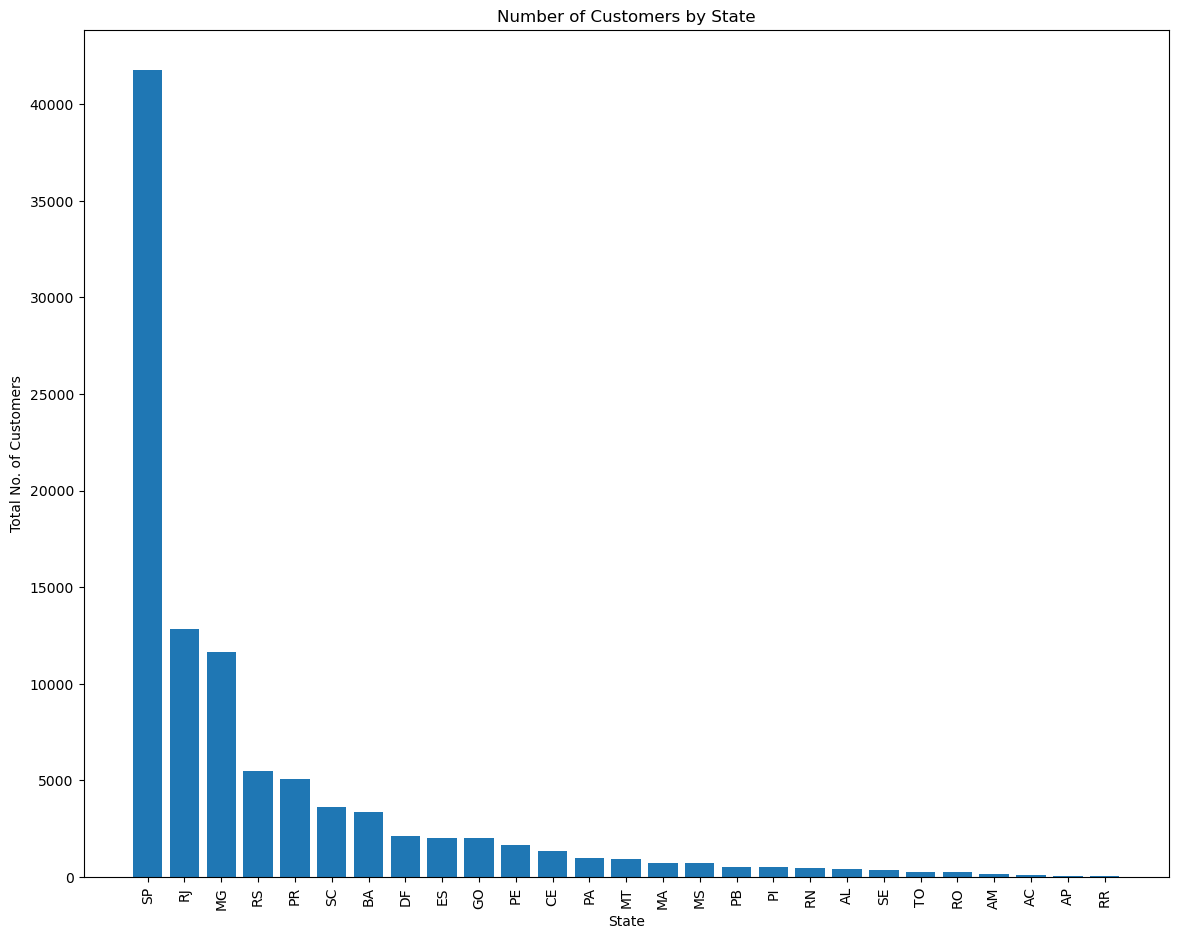

In [36]:
query= """select 
customer_state,
count(customer_id)
from customers
group by customer_state
"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data, columns=["State", "Total No. of Customers"])
df=df.sort_values("Total No. of Customers" , ascending= False)

plt.figure(figsize=(14,11))
plt.bar(df["State"], df["Total No. of Customers"])
plt.xlabel("State")  
plt.ylabel("Total No. of Customers")  
plt.title("Number of Customers by State")
plt.xticks(rotation= 90) 
plt.show()


# Calculate the number of orders per month in 2018.


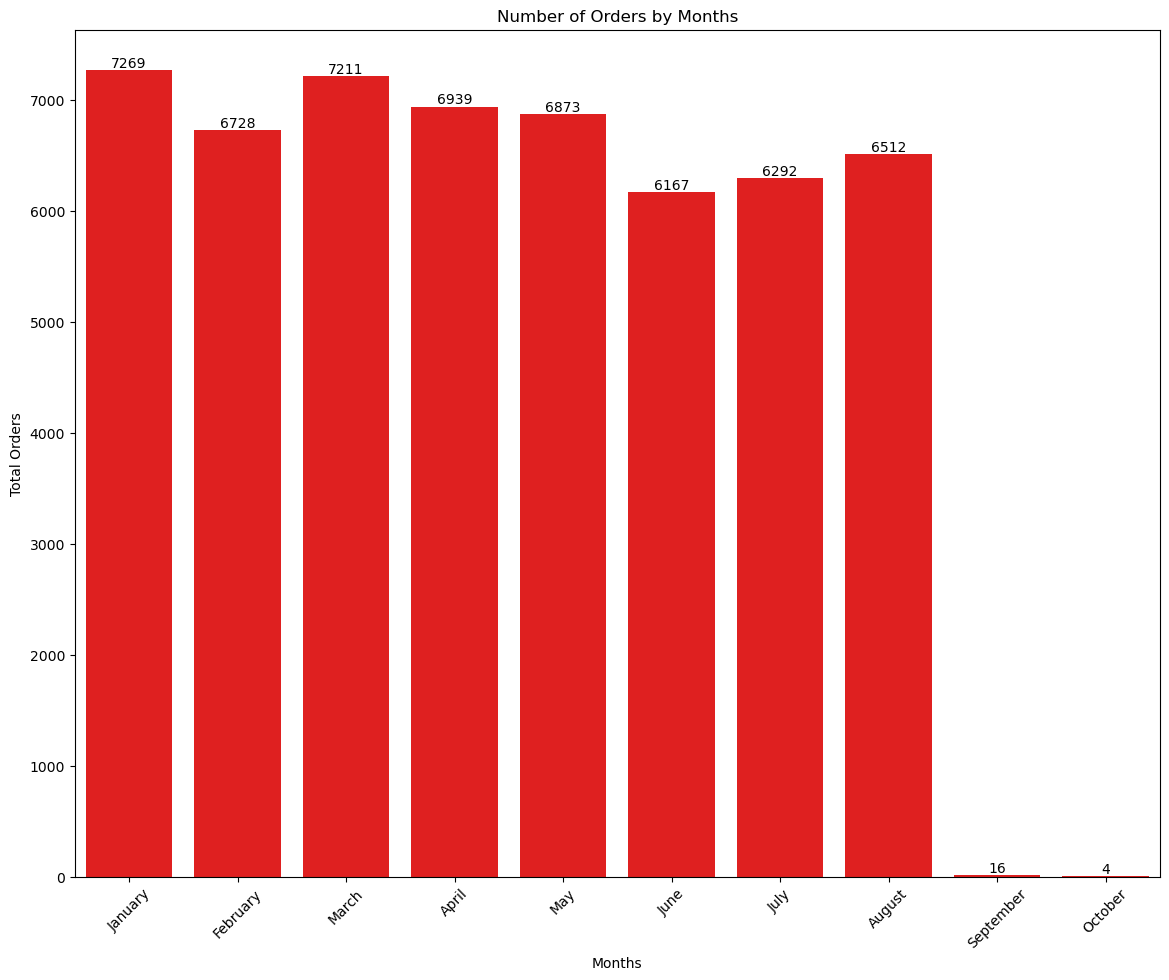

In [70]:
query= """SELECT 
    MonthName(order_purchase_timestamp) AS order_month,
    COUNT(order_id) AS total_orders
FROM 
    orders
WHERE 
    YEAR(order_purchase_timestamp) = 2018
GROUP BY 
    MONTHName(order_purchase_timestamp)


"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data , columns =["Months", "Total Orders"])

plt.figure(figsize=(14,11))
o=["January", "February","March","April","May","June","July","August","September","October"]
ax=sns.barplot(x="Months", y="Total Orders" , data= df, order = o, color="red")
plt.title("Number of Orders by Months")
ax.bar_label(ax.containers[0])
plt.xticks(rotation= 45) 
plt.show()

# Find the average number of products per order, grouped by customer city.


In [77]:
query= """WITH count_per_order AS (
    SELECT 
        orders.order_id,
        orders.customer_id,
        COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items 
    ON orders.order_id = order_items.order_id
    GROUP BY 
        orders.order_id, 
        orders.customer_id
)
SELECT 
    customers.customer_city, 
    Round(AVG(count_per_order.oc) ,2) AS average_orders
FROM 
    customers
JOIN 
    count_per_order 
ON 
    customers.customer_id = count_per_order.customer_id
GROUP BY 
    customers.customer_city
Order by 
     average_orders Desc;


"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data, columns=["Customer City", "Average Products/ Order"])
df.head(10)

,Customer City,Average Products/ Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.


In [87]:
query= """select products.product_category As category,
round((Sum(payments.payment_value) / (select sum(payment_value) from payments)) * 100 , 2) As Sales_Percentage
from products 
join order_items 
on products.product_id= order_items.product_id
join payments 
on payments.order_id= order_items.order_id
group by category 
order by Sales_Percentage DESC """

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data, columns=["Category", "Percentage Distribution"])
df

,Category,Percentage Distribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00


# Identify the correlation between product price and the number of times a product has been purchased.


In [99]:
query = """select
products.product_category,
count(order_items.product_id),
Round(Avg(order_items.price),2)
from products join order_items
on products.product_id= order_items.product_id
group by products.product_category """

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data , columns=["Product Category", "Order Count", "Price"])

arr1=df["Order Count"]
arr2=df["Price"]
a=np.corrcoef(arr1,arr2)
print("The correlation between product price and the number of times a product has been purchased is", a[0][1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.


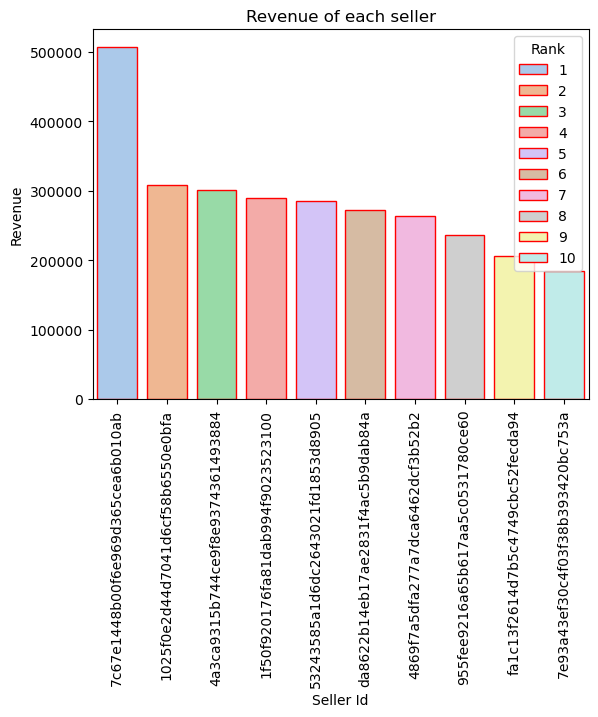

In [110]:
query = """select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) t """

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data, columns=["Seller Id", "Revenue", "Rank"])
df=df.head(10)
sns.barplot(x="Seller Id", y="Revenue", data= df, hue="Rank",palette="pastel",edgecolor="r",linewidth=1)
plt.xticks(rotation=90)
plt.title("Revenue of each seller")
plt.show()

# Calculate the moving average of order values for each customer over their order history.


In [113]:
query= """ Select customer_id, order_purchase_timestamp, payment,
Round (avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) , 2)
from(
select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id= orders.order_id
)t """

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame( data, columns=["Customer ID" , "Order Date", "Payment" , "Moving Average"])
df

,Customer ID,Order Date,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


#  Calculate the cumulative sales per month for each year.


In [122]:
query= """ select 
years, months , payment, 
Round (sum(payment) over(order by years, months) , 2) as Cumulative_sales 
from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) t  """

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame( data, columns=["Order Year" , "Order Month", "Sales" , "Cumulative Sales"])
df

,Order Year,Order Month,Sales,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.


In [136]:
query= """ SELECT 
years, payment, previous_year_sales,
ROUND(((payment - previous_year_sales) / previous_year_sales) * 100, 2) AS YoY_growth
FROM (
SELECT 
YEAR(orders.order_purchase_timestamp) AS years,
ROUND(SUM(payments.payment_value), 2) AS payment,
LAG(ROUND(SUM(payments.payment_value), 2)) OVER (ORDER BY YEAR(orders.order_purchase_timestamp)) AS previous_year_sales
FROM 
orders JOIN payments 
ON orders.order_id = payments.order_id
GROUP BY YEAR(orders.order_purchase_timestamp)
) t

"""

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data, columns=["Years","Sales","Previous Year Sales","YoY % Growth"])
df

,Years,Sales,Previous Year Sales,YoY % Growth
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0


# Identify the top 3 customers who spent the most money in each year.

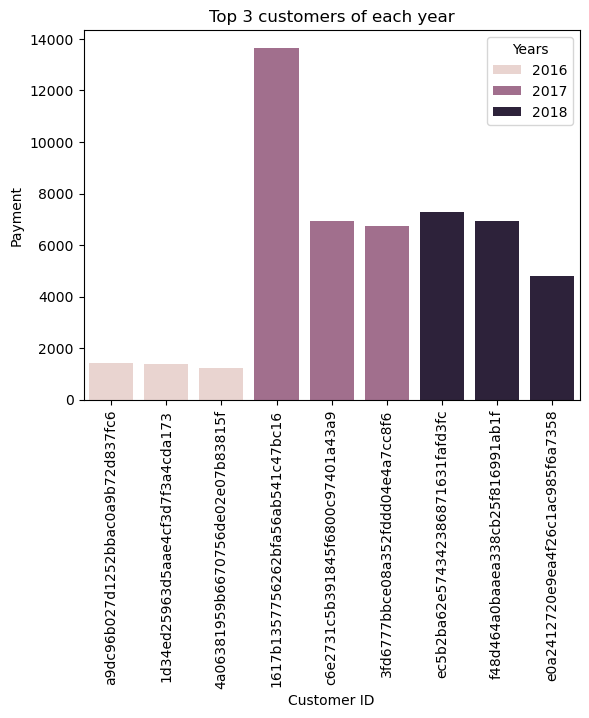

In [140]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years" , "Customer ID" , "Payment", "Rank"])
sns.barplot(x="Customer ID", y="Payment", data= df, hue="Years")
plt.xticks( rotation= 90)
plt.title("Top 3 customers of each year")
plt.show()
